# Preprocessing

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
import torch

In [73]:
from src.vfm.connection import Connection
from src.vfm.preprocessor import Preprocessor
import pandas as pd
from src.vfm.model.reg.gradient_boost import GradientBoost
from src.vfm.model.nn.swt_tft import SWTTFTModel
from src.utils.descriptive_utils import *
from src.vfm.model.physics.physics_informed import PhysicsInformedHybridModel, PhysicsModel
from src.utils import *
import matplotlib.pyplot as plt
import os

In [251]:
connection = Connection()
# Get client
client = connection.get_client()

In [313]:
df_all_wells = connection.get_data(client, wells=get_all_wells())

In [314]:
df_all_wells.columns


Index(['whp', 'wht', 'dhp', 'dht', 'choke', 'dcp', 'qo_well_test',
       'qg_well_test', 'qw_well_test', 'qo_mpfm', 'qg_mpfm', 'wc_mpfm',
       'well_id'],
      dtype='object')

In [315]:
dependent_vars=get_depdendent_vars()
independent_vars=get_independent_vars()

In [316]:
preprocessor = Preprocessor()
df_all_wells_preprocessed = preprocessor.preprocess_timeseries(df=df_all_wells)
len(df_all_wells_preprocessed)

Preprocessing well W06... with columns ['whp', 'wht', 'dhp', 'dht', 'choke', 'dcp', 'qo_well_test', 'qg_well_test', 'qw_well_test', 'qo_mpfm', 'qg_mpfm', 'wc_mpfm', 'well_id']


99

In [317]:
summarize_null(df_all_wells_preprocessed)

dhp          0
dht          0
whp          0
wht          0
dcp          0
choke        0
well_id      0
qo_mpfm      0
qg_mpfm      0
qw_mpfm      0
time_idx     0
well_code    0
dtype: int64

In [318]:
df_with_targets = df_all_wells_preprocessed.dropna(subset=dependent_vars)
df_with_targets.shape

(99, 12)

In [319]:
summarize_null(df_with_targets)

dhp          0
dht          0
whp          0
wht          0
dcp          0
choke        0
well_id      0
qo_mpfm      0
qg_mpfm      0
qw_mpfm      0
time_idx     0
well_code    0
dtype: int64

In [320]:
df_train, df_val, df_test = get_random_train_test_split_per_well_with_order_preserved(df=df_with_targets, test_size=0.2)
len(df_train), len(df_val), len(df_test)

(74, 8, 17)

In [321]:
model = PhysicsInformedHybridModel(dependant_vars=dependent_vars, independent_vars=independent_vars)
model.fit(df=df_train, df_val=df_val)

[Validation] Residual RMSE = 0.6585


In [322]:
model.score_physics(df_test)

{'W06': {'qo': {'r2': 0.903382080819029,
   'mae': 9.758902405555162,
   'rmse': 11.452055457977925},
  'qw': {'r2': -0.896600176110512,
   'mae': 23.934243437144776,
   'rmse': 33.62632233550074},
  'qg': {'r2': 0.8877044608184437,
   'mae': 1253.404860633049,
   'rmse': 1494.4169119923959},
  'wgr': {'r2': -14.026441236301563,
   'mae': 0.0029025473812327378,
   'rmse': 0.005756019721739744}}}

In [323]:
model.score_hybrid(df_test)

{'W06': {'qo': {'r2': 0.903382080819029,
   'mae': 9.758902405555162,
   'rmse': 11.452055457977925},
  'qw': {'r2': 0.2534814480922556,
   'mae': 9.756471775636888,
   'rmse': 21.096566596998734},
  'qg': {'r2': 0.9427024184220005,
   'mae': 918.8206844666809,
   'rmse': 1067.4773459327007},
  'wgr': {'r2': 0.143345431241509,
   'mae': 0.0006553051033561477,
   'rmse': 0.0013743491315284227}}}

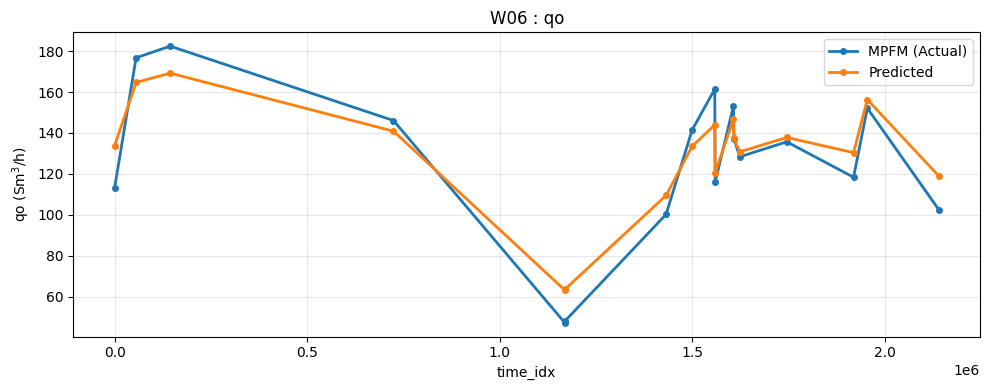

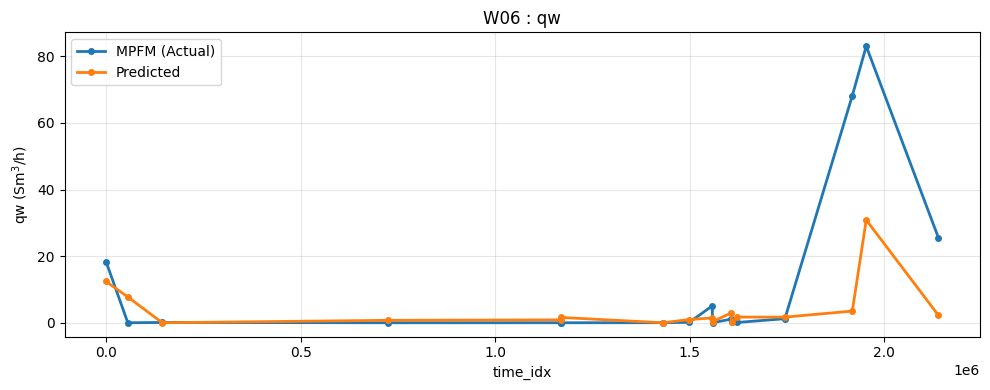

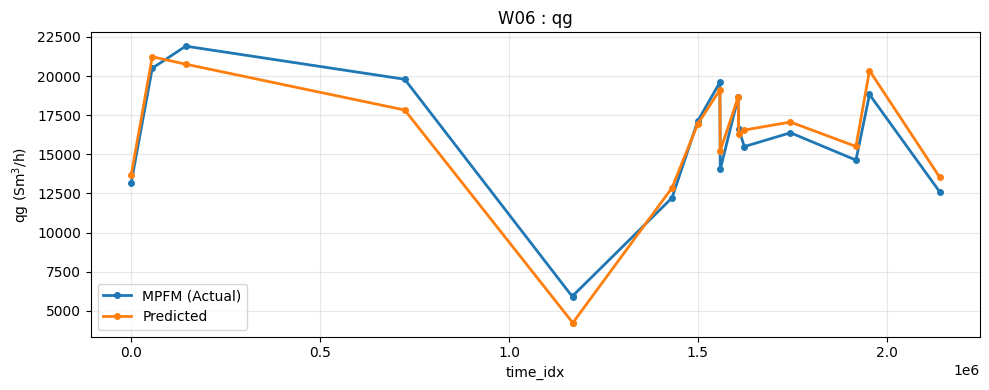

In [324]:
model.plot_predictions(df=df_test, time_col="time_idx", is_hybrid_model=True)

In [325]:
def lowo_with_partial_calibration(
    df,
    n_calibration_points=2,
):
    results = []

    for test_well in df["well_id"].unique():
        df_well = df[df["well_id"] == test_well]
        df_train_other = df[df["well_id"] != test_well]

        df_cal = df_well.iloc[:n_calibration_points]
        df_test = df_well.iloc[n_calibration_points:]

        df_train = pd.concat([df_train_other, df_cal])

        model = PhysicsInformedHybridModel(dependant_vars=dependent_vars, independent_vars=independent_vars)
        # model.phys_model.fit_pres = False
        model.fit(df_train)

        results.append({
            "well": test_well,
            "scores": model.hybrid_score(df_test)
        })

    return results


In [326]:
# lowo_with_partial_calibration(df=df_with_targets)